# Data Science project: CIRI

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import re
import math

from torch.utils.data import DataLoader
from PIL import Image

## Generic setup

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [2]:
rng = np.random.default_rng(0)

## Load datasets

Because the dataset contains images with a filename starting with a dot ("."), these files are hidden, giving problems down the line with reading. As such, rename them by adding "img" as a filename prefix.

In [3]:
base_path = "./data/Incidents-subset"
directories = os.listdir(os.path.expanduser(base_path))
for directory in directories:
    files = os.listdir(os.path.expanduser(base_path + "/" + directory))
    for file in files:
        if re.match(r".*.((jpg)|(png)|(jpeg))", file, re.IGNORECASE) and not re.match(r"img.*", file):
            os.rename(os.path.expanduser(base_path + "/" + directory + "/" + file), os.path.expanduser(base_path + "/" + directory + "/img" + file))

Some images are corrupted, so we need a check whether this is the case before images are added to the dataset. This is done by calling the function below in the `is_valid_file` parameter of the `ImageFolder` function.

In [4]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

For transformation and normalization, we use the same parameter as used in the paper source code.

> Weber, E., Papadopoulos, D.P., Lapedriza, A., Ofli, F., Imran, M. and Torralba, A. 2022. Incidents1M: a large-scale dataset of images with natural disasters, damage, and incidents. arXiv.

Source code: https://github.com/ethanweber/IncidentsDataset.


In [5]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

data = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

targets = [target for (_, target) in data]
number_of_classes = len(data.classes)

/home/jovyan/2022-1B-DS-CIRI-Project/env/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Next, we split the data into five folds to allow us to perform cross-validation.

In [6]:
# Use a seed to ensure we can get the same exact split later for augmentation
data_fold1, data_fold2, data_fold3, data_fold4, data_fold5 = torch.utils.data.random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2],
                                                      generator=torch.Generator().manual_seed(42))
data_fold_list = [data_fold1, data_fold2, data_fold3, data_fold4, data_fold5]

targets_fold1 = [target for (_, target) in data_fold1]
targets_fold2 = [target for (_, target) in data_fold2]
targets_fold3 = [target for (_, target) in data_fold3]
targets_fold4 = [target for (_, target) in data_fold4]
targets_fold5 = [target for (_, target) in data_fold5]
targets_fold_list = [targets_fold1, targets_fold2, targets_fold3, targets_fold4, targets_fold5]

dataloader_fold1 = DataLoader(data_fold1, batch_size=4, shuffle=False)
dataloader_fold2 = DataLoader(data_fold2, batch_size=4, shuffle=False)
dataloader_fold3 = DataLoader(data_fold3, batch_size=4, shuffle=False)
dataloader_fold4 = DataLoader(data_fold4, batch_size=4, shuffle=False)
dataloader_fold5 = DataLoader(data_fold5, batch_size=4, shuffle=False)

## Visualise datasets

### General information

In [7]:
print(f"Number of items in dataset: {len(data)}")
print(f"Number of items in fold 1: {len(data_fold1)}")
print(f"Number of items in fold 2: {len(data_fold2)}")
print(f"Number of items in fold 3: {len(data_fold3)}")
print(f"Number of items in fold 4: {len(data_fold4)}")
print(f"Number of items in fold 5: {len(data_fold5)}")
print(f"Number of classes: {number_of_classes}")

Number of items in dataset: 7357
Number of items in fold 1: 1472
Number of items in fold 2: 1472
Number of items in fold 3: 1471
Number of items in fold 4: 1471
Number of items in fold 5: 1471
Number of classes: 12


### Class distribution

First, we assess the number of images per class in each of the folds. This provides us with a rough idea of the distribution in the dataset.

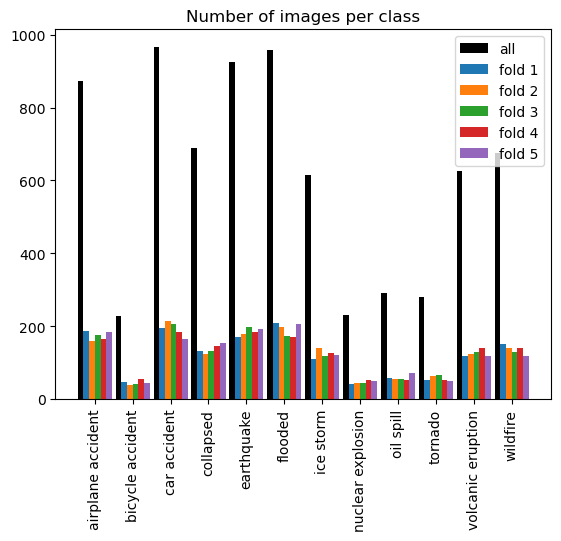

In [8]:
unique_targets, unique_target_counts = np.unique(
    targets,
    return_counts=True
)
unique_targets_fold1, unique_target_counts_fold1 = np.unique(
    targets_fold1,
    return_counts=True
)
unique_targets_fold2, unique_target_counts_fold2 = np.unique(
    targets_fold2,
    return_counts=True
)
unique_targets_fold3, unique_target_counts_fold3 = np.unique(
    targets_fold3,
    return_counts=True
)
unique_targets_fold4, unique_target_counts_fold4 = np.unique(
    targets_fold4,
    return_counts=True
)
unique_targets_fold5, unique_target_counts_fold5 = np.unique(
    targets_fold5,
    return_counts=True
)


# Assert that all folds contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_fold1) == number_of_classes, "Fold 1 set must contain all classes"
assert len(unique_targets_fold2) == number_of_classes, "Fold 2 set must contain all classes"
assert len(unique_targets_fold3) == number_of_classes, "Fold 3 set must contain all classes"
assert len(unique_targets_fold4) == number_of_classes, "Fold 4 set must contain all classes"
assert len(unique_targets_fold5) == number_of_classes, "Fold 5 set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(number_of_classes) - 0.375,
        unique_target_counts,
        width=0.15,
        label="all",
        color="black")
plt.bar(np.arange(number_of_classes) -0.225,
        unique_target_counts_fold1,
        width=0.15,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="fold 1")
plt.bar(np.arange(number_of_classes) - 0.075,
        unique_target_counts_fold2,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 2")
plt.bar(np.arange(number_of_classes) + 0.075,
        unique_target_counts_fold3,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 3")
plt.bar(np.arange(number_of_classes) + 0.225,
        unique_target_counts_fold4,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 4")
plt.bar(np.arange(number_of_classes) + 0.375,
        unique_target_counts_fold5,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 5")
plt.xticks(np.arange(number_of_classes),
           labels=data.classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

The plot shows that the data in the dataset is unbalanced. For example, the "car accident" class sees a much larger occurrence than the "nuclear explosion" class. This imbalance could lead to issues later with the model not performing well for certain underrepresented classes. Dataset imbalance can be mitigated in multiple ways: oversampling and undersampling. An example of oversampling is data augmentation, a process in which images undergo a certain modification, such as a horizontal flip, to "augment" the dataset with "new" training images. Undersampling can be done by removing samples from overrepresented classes to bring them more in line with other classes present in the data.

### Data augmentation and undersampling

To achieve a balanced dataset, the number of samples per class will be set to four times the number of samples in the smallest class. For some classes, this means undersampling: removing a number of samples from the class. For others, this means augmenting the data.

For the overrepresented classes, number of "excess" images will be calculated. A random set of images amounting to this number will be removed from the corresponding class.
For each of the underrepresented classes, the number of required augmentations will be calculated. This number of augmentations will be covered by three kinds augmentations, with each augmentation covering a third of the required augmentations. Images to be augmented will be chosen at random from the set of images in the class. The first augmentation option will be a horizontal flip, the second will a rotation between 10 and 20 degrees, the third and final one will be a 50% increase in saturation. After the augmentations are complete, the augmentation sets will be added to the original image set for the corresponding class.

It is important to ensure that there is no leakage from the train folds to the test folds when performing augmentation, as this might skew the model performance. Hence the data has already been split in five folds, which will each be augmented separately. This ensures image "isotopes" created by augmenting images will stay in the same fold as the original.

In [9]:
# Extract the data three more times, once for each augmentation
data_aug1 = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

data_aug2 = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

data_aug3 = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

# Use the same seed as used earlier to ensure the random split is exactly the same
data_fold1_aug1, data_fold2_aug1, data_fold3_aug1, data_fold4_aug1, data_fold5_aug1 = torch.utils.data.random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2],
                                                      generator=torch.Generator().manual_seed(42))

data_fold1_aug2, data_fold2_aug2, data_fold3_aug2, data_fold4_aug2, data_fold5_aug2 = torch.utils.data.random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2],
                                                      generator=torch.Generator().manual_seed(42))

data_fold1_aug3, data_fold2_aug3, data_fold3_aug3, data_fold4_aug3, data_fold5_aug3 = torch.utils.data.random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2],
                                                      generator=torch.Generator().manual_seed(42))

data_fold_list_aug1 = [data_fold1_aug1, data_fold2_aug1, data_fold3_aug1, data_fold4_aug1, data_fold5_aug1]
data_fold_list_aug2 = [data_fold1_aug2, data_fold2_aug2, data_fold3_aug2, data_fold4_aug2, data_fold5_aug2]
data_fold_list_aug3 = [data_fold1_aug3, data_fold2_aug3, data_fold3_aug3, data_fold4_aug3, data_fold5_aug3]

In [10]:
# Define two functions, one for each augmentation
def AugmentHorizontalFlip(n_augs, targets, data):
    relevant_image_index_list = []

    for class_id in range(0, number_of_classes):
        # If the number of required augmentations is 0 for this class, skip to
        # the next. This is faster and prevents an exception in rng.choice.
        if n_augs[class_id] < 0:
            continue

        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]

        # Randomly pick a third of the images to be augmented, rounding up to
        # account for situations in which n_augs[class_id]%3 != 0
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=math.ceil(n_augs[class_id]/3),
            replace=False
        )

        # Save the sampled image indices to be able to return only those images
        relevant_image_index_list.append(sampled_image_indices)

        # Compose the transform, in this case a horizontal flip
        horizontalFlip_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(1),
        ])

        # Apply the transform to each underrepresented class image
        for image_index in sampled_image_indices:
            horizontalFlip_transform(data[image_index][0])

    # Return only a subset of the data to prevent duplicates that were not augmented
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))


def AugmentRotation(n_augs, targets, data):
    relevant_image_index_list = []

    for class_id in range(0, number_of_classes):
        # If the number of required augmentations is 0 for this class, skip to
        # the next. This is faster and prevents an exception in rng.choice.
        if n_augs[class_id] < 0:
            continue

        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]

        # Randomly pick a third of the images to be augmented, rounding to
        # account for situations in which n_augs[class_id]%3 != 0
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=round(n_augs[class_id]/3),
            replace=False
        )

        # Save the sampled image indices to be able to return only those images
        relevant_image_index_list.append(sampled_image_indices)

        # Compose the transform, in this case a rotation between 10 and 20 degrees
        rotation_transform = transforms.Compose([
            transforms.RandomRotation((10, 20)),
        ])

        # Apply the transform to each underrepresented class image
        for image_index in sampled_image_indices:
            rotation_transform(data[image_index][0])

    # Return only a subset of the data to prevent duplicates that were not augmented
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))


def AugmentSaturation(n_augs, targets, data):
    relevant_image_index_list = []

    for class_id in range(0, number_of_classes):
        # If the number of required augmentations is 0 for this class, skip to
        # the next. This is faster and prevents an exception in rng.choice.
        if n_augs[class_id] < 0:
            continue

        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]

        # Randomly pick a third of the images to be augmented, rounding down to
        # account for situations in which n_augs[class_id]%3 != 0
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=math.floor(n_augs[class_id]/3),
            replace=False
        )

        # Save the sampled image indices to be able to return only those images
        relevant_image_index_list.append(sampled_image_indices)

        # Apply the transform to each underrepresented class image
        for image_index in sampled_image_indices:
            transforms.functional.adjust_saturation(data[image_index][0], 1.5)

    # Return only a subset of the data to prevent duplicates that were not augmented
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))


def UndersampleData(n_removals, desired_sample_count, targets, data):
    relevant_image_index_list = []

    for class_id in range(0, number_of_classes):
        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]

        # Pytorch is icky with removing specific data points, so we must
        # flip the concept of removing points. Instead randomly pick the
        # appropriate number of samples that must be retained
        if n_removals[class_id] < 0:
            removal_size = 0
        else:
            removal_size = n_removals[class_id]
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=desired_sample_count - removal_size,
            replace=False
        )

        relevant_image_index_list.append(sampled_image_indices)

    # Return the dataset with necessary sample removal complete
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))

In [11]:
def BalanceFold(targets_fold, data_fold, data_fold_aug1, data_fold_aug2, data_fold_aug3):
    # Create a list of how many samples must be added or removed per class to reach
    # 4x the smallest class's number of samples per class.
    samples_list = []
    for class_id in range(0, number_of_classes):
        samples_list.append(len((np.array(targets_fold) == class_id).nonzero()[0]))

    desired_sample_count = 4 * min(samples_list)
    for class_id in range(0, number_of_classes):
        samples_list[class_id] = desired_sample_count - samples_list[class_id]

    # Call the three augmentation functions
    data_fold_aug1 = AugmentHorizontalFlip(samples_list, targets_fold, data_fold_aug1)
    data_fold_aug2 = AugmentRotation(samples_list, targets_fold, data_fold_aug2)
    data_fold_aug3 = AugmentSaturation(samples_list, targets_fold, data_fold_aug3)

    # Call the undersampling function
    data_fold = UndersampleData(samples_list, desired_sample_count, targets_fold, data_fold)

    # Concatenate the two resulting augmentated datasets to the original set and update the target list
    data_fold = torch.utils.data.ConcatDataset([data_fold, data_fold_aug1, data_fold_aug2, data_fold_aug3])
    targets_fold = [target for (_, target) in data_fold]
    return data_fold, targets_fold

In [12]:
# Loop over the five folds and balance each one separately
for k in range(0, 5):
    data_fold_list[k], targets_fold_list[k] = BalanceFold(targets_fold_list[k], data_fold_list[k], data_fold_list_aug1[k], data_fold_list_aug2[k], data_fold_list_aug3[k])

Running the code below shows the result of the augmentation. The original data size is still the same as before, but the folds increased in size. Further down, the same can be seen in the barplot.
A limitation here is that because the data is balanced within a fold, the folds do not have the same size. This is due to the initial class imbalance in the folds. Each fold is balanced to having 4 times the minimum sample count per class, which is a number that is different in each fold. As such, the size of the folds varies.
This was accepted because we are looking to mitigate class balance, not necessarily equalise fold size, and that is achieved by this method.

In [21]:
print(f"Number of items in dataset: {len(data)}")
print(f"Number of items in fold 1: {len(data_fold_list[0])}")
print(f"Number of items in fold 2: {len(data_fold_list[1])}")
print(f"Number of items in fold 3: {len(data_fold_list[2])}")
print(f"Number of items in fold 4: {len(data_fold_list[3])}")
print(f"Number of items in fold 5: {len(data_fold_list[4])}")
print(f"Number of classes: {number_of_classes}")

Number of items in dataset: 7357
Number of items in fold 1: 2016
Number of items in fold 2: 1824
Number of items in fold 3: 2016
Number of items in fold 4: 2448
Number of items in fold 5: 2160
Number of classes: 12


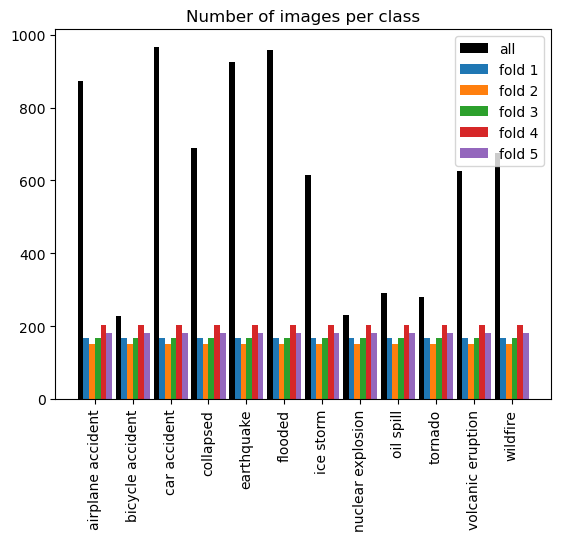

In [20]:
unique_targets, unique_target_counts = np.unique(
    targets,
    return_counts=True
)
unique_targets_fold1, unique_target_counts_fold1 = np.unique(
    targets_fold_list[0],
    return_counts=True
)
unique_targets_fold2, unique_target_counts_fold2 = np.unique(
    targets_fold_list[1],
    return_counts=True
)
unique_targets_fold3, unique_target_counts_fold3 = np.unique(
    targets_fold_list[2],
    return_counts=True
)
unique_targets_fold4, unique_target_counts_fold4 = np.unique(
    targets_fold_list[3],
    return_counts=True
)
unique_targets_fold5, unique_target_counts_fold5 = np.unique(
    targets_fold_list[4],
    return_counts=True
)

# Assert that all folds contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_fold1) == number_of_classes, "Fold 1 set must contain all classes"
assert len(unique_targets_fold2) == number_of_classes, "Fold 2 set must contain all classes"
assert len(unique_targets_fold3) == number_of_classes, "Fold 3 set must contain all classes"
assert len(unique_targets_fold4) == number_of_classes, "Fold 4 set must contain all classes"
assert len(unique_targets_fold5) == number_of_classes, "Fold 5 set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(number_of_classes) - 0.375,
        unique_target_counts,
        width=0.15,
        label="all",
        color="black")
plt.bar(np.arange(number_of_classes) -0.225,
        unique_target_counts_fold1,
        width=0.15,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="fold 1")
plt.bar(np.arange(number_of_classes) - 0.075,
        unique_target_counts_fold2,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 2")
plt.bar(np.arange(number_of_classes) + 0.075,
        unique_target_counts_fold3,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 3")
plt.bar(np.arange(number_of_classes) + 0.225,
        unique_target_counts_fold4,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 4")
plt.bar(np.arange(number_of_classes) + 0.375,
        unique_target_counts_fold5,
        width=0.15,
        # color="none",
        # edgecolor="black",
        label="fold 5")
plt.xticks(np.arange(number_of_classes),
           labels=data.classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

### Sample images

As a result of the normalization performed earlier, the images cannot be displayed as-is without clipping. Hence, we need a way to inverse the normalization before displaying the images. We do this through the use of a `Transform`.

In [16]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    Code from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


inverse_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Now, we actually visualise the images.

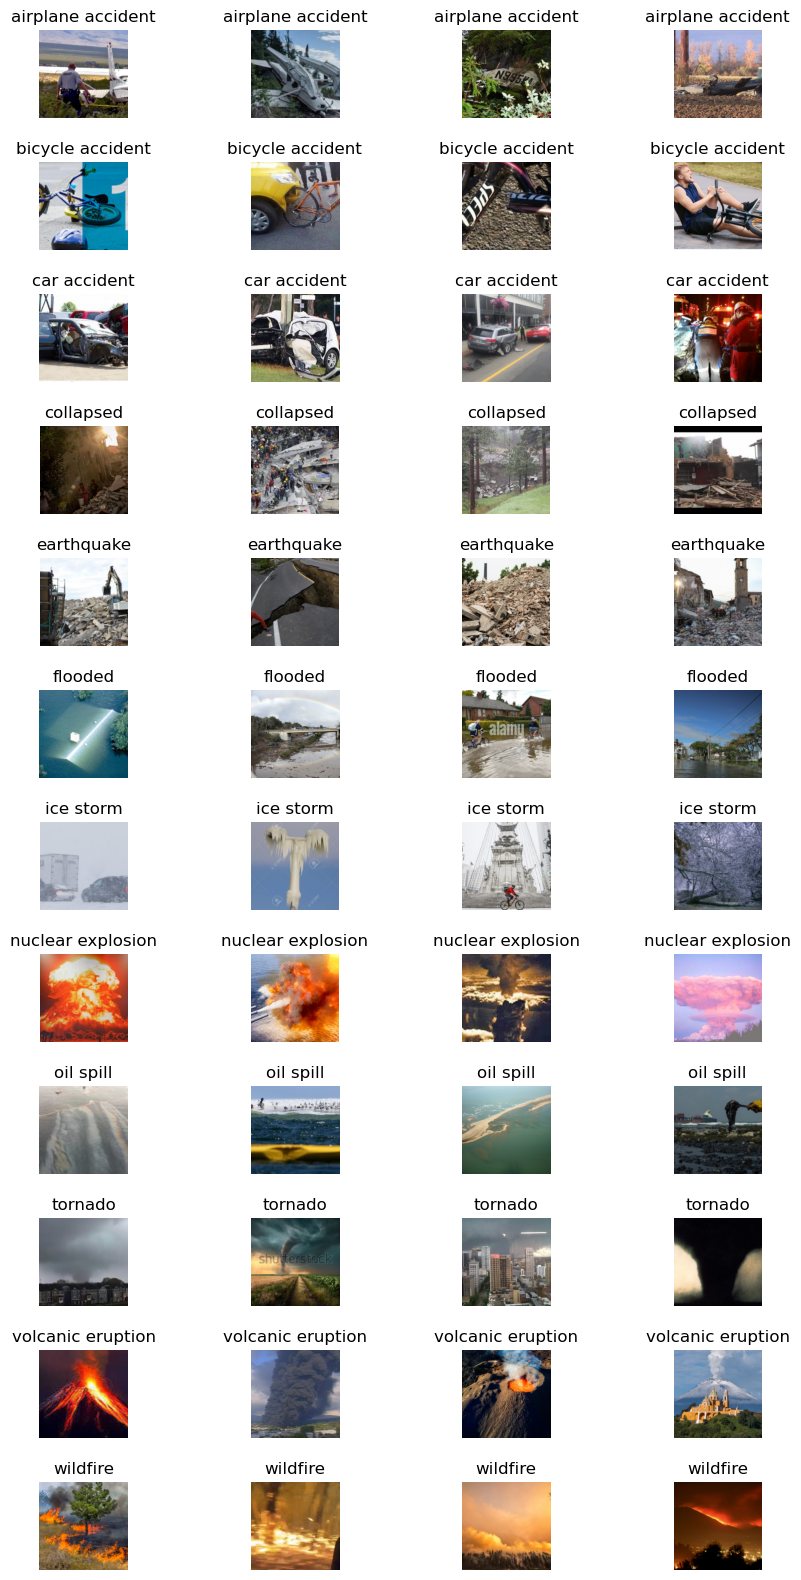

In [17]:
number_of_images_per_class = 4

# Create plots with sufficient size and spacing
fig, axs = plt.subplots(number_of_classes,
                        number_of_images_per_class,
                        figsize=(10, 20))
plt.subplots_adjust(hspace=.5, wspace=.5)

for target_class in range(0, number_of_classes):
    # Create a mask for the dataset to include only images for this class
    relevant_image_indices = (np.array(targets) == target_class).nonzero()[0]

    # Randomly sample images from all relevant images
    sampled_image_indices = rng.choice(
        a=relevant_image_indices,
        size=number_of_images_per_class,
        replace=False
    )

    # Display the images with the proper title
    for i, image_index in enumerate(sampled_image_indices):
        ax = axs[target_class, i]
        ax.imshow(
            # Clamp to prevent values just outside the [0,1] range (as a result of inverse normalisation)
            torch.clamp(inverse_normalize(data[image_index][0]).permute(1,2,0), 0, 1),
            vmin=0,
            vmax=1)
        ax.axis("off")
        ax.set_title(data.classes[target_class])

## Saving the prepared data

To be able to use the data that was prepared in this notebook, it must be saved so it can be loaded in the model notebook. This will be done using torch.save().

In [ ]:
if not os.path.exists('./content'):
    os.mkdir('./content')
    for k in range(0, 5):
        os.mkdir('./content/fold{}_loader'.format(k))
        os.mkdir('./content/fold{}_loader/img'.format(k))
        os.mkdir('./content/fold{}_loader/target'.format(k))

with open('./content/data_classes.bin', 'wb') as file:
    pickle.dump(data.classes, file)

for k in range(0, 5):
    for i, data in enumerate(data_fold_list[k]):
        torch.save(data[0], './content/fold{}_loader/img/train_prepped_img{}'.format(k, i))
        torch.save(data[1], './content/fold{}_loader/target/train_prepped_target{}'.format(k, i))